# Data Analysis: Visualization

Once the data is cleaned and I have extracted the necessary features, I proceed to do a visual analysis to extract insights.

1. [Get cleaned data](#Get-cleaned-data)
2. [Get Zone Name and attach to data](#Get-Zone-Name-and-attach-to-data)
3. [Histogram Comparison: Pickups per Zone](#Histogram-Comparison,-Pickups-per-Zone)
4. [Map, pickups by zone](#Map,-pickups-by-zone)
5. [Linear Chart: Pickups evolution over time](#Linear-Chart,-Pickups-evolution-over-time)
6. [Scatter Plot, Relation between Precipitation and Pickups](#Scatter-Plot,-Relation-between-Precipitation-and-Pickups)
7. [Pairwise Relationships](#Pairwise-Relationships)
8. [Pickups in Rainy Day vs Not Rainy Days](#Pickups-in-Rainy-Day-vs-Not-Rainy-Days)
9. [Conclusions](#Conclusions)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 5)
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None
import altair as alt

# alt.data_transformers.disable_max_rows()

In [2]:
%matplotlib inline

# Get cleaned data
<div style = "float:right"><a style="text-decoration:none" href = "#Data-Analysis:-Visualization">Up</a></div>

In [3]:
year=2019

df = pd.read_csv('../data/Data_Cleaned_'+str(year)+'_To_Model.csv', sep=',',
                       parse_dates=['datetime'])
df = df.rename(columns={'NoOfPickups':'pickups'})

df.head()

,datetime,month,day,hour,LocationID,pickups,year,week,dayofweek,isweekend,isholiday,precipitation
0,2019-01-01,1,1,0,4,49.0,2019,1,1,0,1,0.13
1,2019-01-01,1,1,0,12,4.0,2019,1,1,0,1,0.13
2,2019-01-01,1,1,0,13,64.0,2019,1,1,0,1,0.13
3,2019-01-01,1,1,0,24,53.0,2019,1,1,0,1,0.13
4,2019-01-01,1,1,0,41,82.0,2019,1,1,0,1,0.13


# Get Zone Name and attach to data
<div style = "float:right"><a style="text-decoration:none" href = "#Data-Analysis:-Visualization">Up</a></div>

In [4]:
# 1. Import Location and Borough columns form NY TAXI ZONES dataset
dfzones = pd.read_csv('../data/NY_taxi_zones.csv', sep=',',
                      usecols=['LocationID', 'borough', 'zone'])

# 2. Filter Manhattan zones
dfzones = dfzones[dfzones['borough']=='Manhattan']\
                .drop(['borough'], axis=1)\
                .sort_values(by='LocationID')\
                .drop_duplicates('LocationID').reset_index(drop=True)
dfzones.head()

,zone,LocationID
0,Alphabet City,4
1,Battery Park,12
2,Battery Park City,13
3,Bloomingdale,24
4,Central Harlem,41


In [5]:
df2 = df.merge(dfzones, left_on='LocationID', right_on='LocationID')
df2.head()

,datetime,month,day,hour,LocationID,pickups,year,week,dayofweek,isweekend,isholiday,precipitation,zone
0,2019-01-01 00:00:00,1,1,0,4,49.0,2019,1,1,0,1,0.13,Alphabet City
1,2019-01-01 01:00:00,1,1,1,4,94.0,2019,1,1,0,0,0.02,Alphabet City
2,2019-01-01 02:00:00,1,1,2,4,83.0,2019,1,1,0,0,0.00,Alphabet City
3,2019-01-01 03:00:00,1,1,3,4,85.0,2019,1,1,0,0,0.02,Alphabet City
4,2019-01-01 04:00:00,1,1,4,4,43.0,2019,1,1,0,0,0.00,Alphabet City


# Histogram Comparison, Pickups per Zone
<div style = "float:right"><a style="text-decoration:none" href = "#Data-Analysis:-Visualization">Up</a></div>

The plot shows Manhattan zones ordered by their average number of pickups over the year.

The top ten zones by pickups here:

In [6]:
df_grouped = df2[['zone', 'pickups']]
df_grouped = df_grouped.groupby('zone').mean().sort_values('pickups', ascending=False).reset_index()
display(df_grouped.head(10))

# all zones sum
all_sum = df_grouped.sum(axis=0)[1]

# top 10 zones sum
df_grouped_top10 = df_grouped[0:10]
top10_sum = df_grouped_top10.sum(axis=0)[1]

print('Total sum of pickups: ', int(all_sum))
print('Top 10 zones sum of pickups: ', int(top10_sum))
print('The top 10 zones get {0}% of the pickups'.format(int(top10_sum/all_sum*100)))

,zone,pickups
0,Upper East Side South,413.364612
1,Midtown Center,391.063927
2,Upper East Side North,373.749772
3,Midtown East,345.385731
4,Penn Station/Madison Sq West,343.067808
5,Times Sq/Theatre District,327.807078
6,Clinton East,302.809703
7,Murray Hill,294.890068
8,Union Sq,287.553425
9,Lincoln Square East,287.354224


Total sum of pickups:  8664
Top 10 zones sum of pickups:  3367
The top 10 zones get 38% of the pickups


In [7]:
df_grouped = df2[['zone', 'pickups']]
df_grouped = df_grouped.groupby('zone').mean().sort_values('pickups', ascending=False).reset_index()

pickups_by_zone = alt.Chart(df_grouped).mark_bar().encode(
    x=alt.X('zone',
            sort=alt.Sort(field='pickups',
                         order='descending')
    ),
    y='pickups',
    tooltip='zone'
).properties(
    width=800
)
pickups_by_zone

alt.Chart(...)

# Map, pickups by zone
<div style = "float:right"><a style="text-decoration:none" href = "#Data-Analysis:-Visualization">Up</a></div>

The following choropleth map shows Manhattan taxi zones by number of pickups.
Top ten are highlighted in red.

In [8]:
import geopandas as gpd

# Get shape file. Only Manahattan borough
df_shape = gpd.read_file('../data/taxi_zones/taxi_zones.shp').to_crs(epsg=3785)
df_shape = df_shape.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
df_shape = df_shape[df_shape['borough'] == 'Manhattan']

# Get the average 'pickups' by 'LocationID' and cast the number to integer
df3 = df[['LocationID', 'pickups']]
df3 = df3.groupby('LocationID').mean().reset_index()
df3 = df3.astype({"pickups": int})

# Merge 'pickups' with geometry
df_shape_merged = df3.merge(df_shape, left_on='LocationID', right_on='LocationID')
df_shape_merged.head(3)

,LocationID,pickups,zone,borough,geometry
0,4,16,Alphabet City,Manhattan,"POLYGON ((-8234500.227 4971984.094, -8234502.1..."
1,12,4,Battery Park,Manhattan,"POLYGON ((-8239385.311 4968901.615, -8239356.3..."
2,13,83,Battery Park City,Manhattan,"POLYGON ((-8239027.255 4970990.635, -8239068.9..."


In [9]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LinearColorMapper, HoverTool
from bokeh.palettes import Cividis256 as palette
from bokeh.io import output_notebook, show
from shapely.geometry import Polygon, MultiPolygon
output_notebook()

# Funtion to transform geometry polygons into 'X' and 'Y' coordinates
def XY_from_shape(shape_data):
    data = []
    for zonename, LocationID, shape, pickups in shape_data[["zone", "LocationID", "geometry", "pickups"]].values:
        #If shape is polygon, extract X and Y coordinates of boundary line:
        if isinstance(shape, Polygon):
            X, Y = shape.boundary.xy
            X = [int(x) for x in X]
            Y = [int(y) for y in Y]
            data.append([LocationID, zonename, X, Y, pickups])

        #If shape is Multipolygon, extract X and Y coordinates of each sub-Polygon:
        if isinstance(shape, MultiPolygon):
            for poly in shape:
                X, Y = poly.boundary.xy
                X = [int(x) for x in X]
                Y = [int(y) for y in Y]
                data.append([LocationID, zonename, X, Y, pickups])

    #Create new DataFrame with X an Y coordinates separated:
    shape_data = pd.DataFrame(data, columns=["LocationID", "ZoneName", "X", "Y", 'pickups'])
    return shape_data

# Get Manhattan geometry and top10 zones geometry
shape_data = XY_from_shape(df_shape_merged)
top10 = shape_data.sort_values('pickups', ascending=False)
top10 = top10[:10]


# Create 'ColumnDataSource' object and 'LinearColorMapper'
source = ColumnDataSource(shape_data)
source_top10 = ColumnDataSource(top10)

max_passengers_per_hour = df_shape_merged['pickups'].max()
color_mapper = LinearColorMapper(palette=palette[::-1], high=max_passengers_per_hour, low=0)

# Create 'figure'
p = figure(title="Taxi Zones by number of pickups (top 10 in red)",
           plot_width=450, plot_height=750,
           toolbar_location=None,
           tools='pan,wheel_zoom,box_zoom,reset,save')

# Create 'patches'
patches = p.patches(xs="X", ys="Y", source=source,
                  fill_color={'field': 'pickups', 'transform': color_mapper},
                  line_color="black")

patches_top10 = p.patches(xs="X", ys="Y", source=source_top10,
                  fill_color={'field': 'pickups', 'transform': color_mapper},
                  line_color="red", line_width=3)

# Create hover efect
hovertool = HoverTool(tooltips=[('ZoneName:', "@ZoneName"),
                                ("pickups:", "@pickups")])
p.add_tools(hovertool)
show(p)

Loading BokehJS ...

# Linear Chart, Pickups evolution over time
<div style = "float:right"><a style="text-decoration:none" href = "#Data-Analysis:-Visualization">Up</a></div>

#### 4.1. Pickups evolution over Months
- The number of pickups over the year is quite constant.
- The only variation is a small decrease of pickups over the Summer months: July and August. This can mean that most taxis are taken by new yorkers (not tourists), and in this period new yorkers travel away from the city.

#### 4.2. Pickups evolution over Weeks
- This graph shows better how the taxi demand drops drastically on the USA Federal holidays:
    - New Year's Day: 1st January.
    - Independence Day: 4th July.
    - Labor Day: first Monday of September.
    - Thanksgiving: 4th Thursday of November.
    
#### 4.3. Pickups evolution over a Single Week
- This graph shows the average number of pickups per weekday:
    - Monday and Sunday are a bit quieter than the other days, but not much.
    
#### 4.4. Pickups evolution over a Day
- This graph shows the average number of pickups over a day:
    - 18:00 and 19:00 are the peak hours.
    - 1:00 am to 6:00 am the quieter.

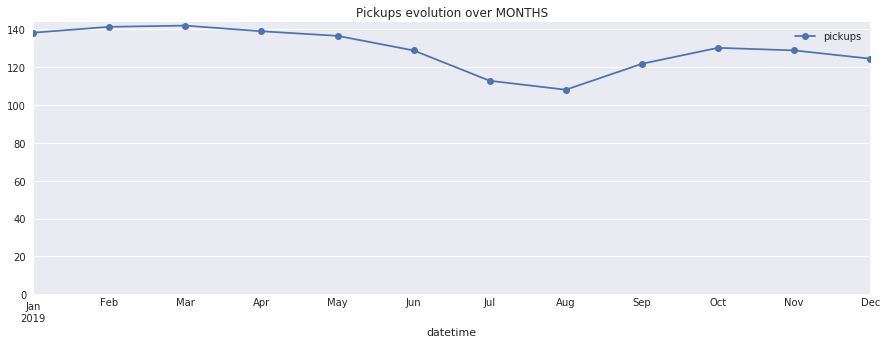

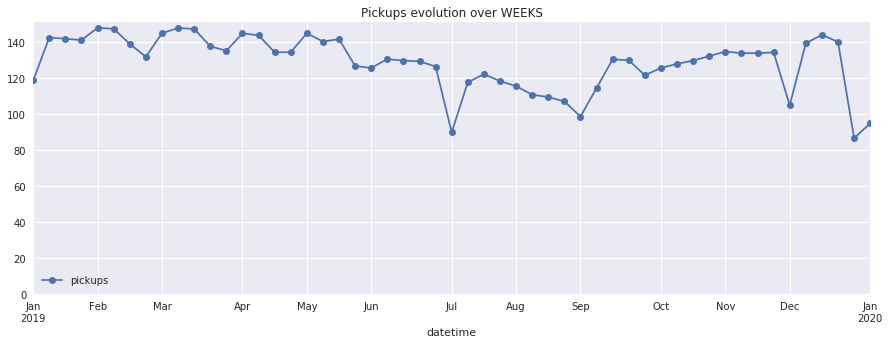

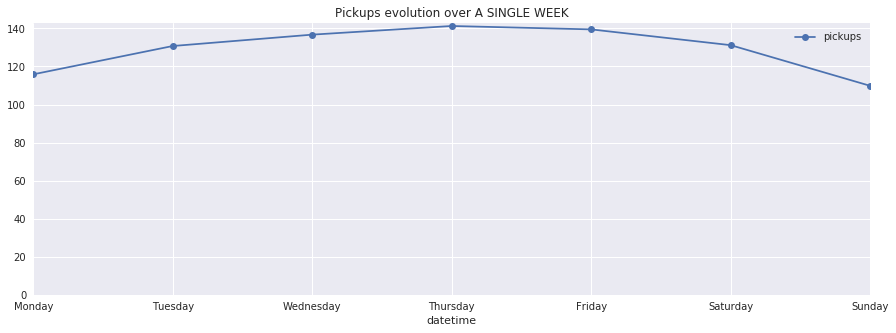

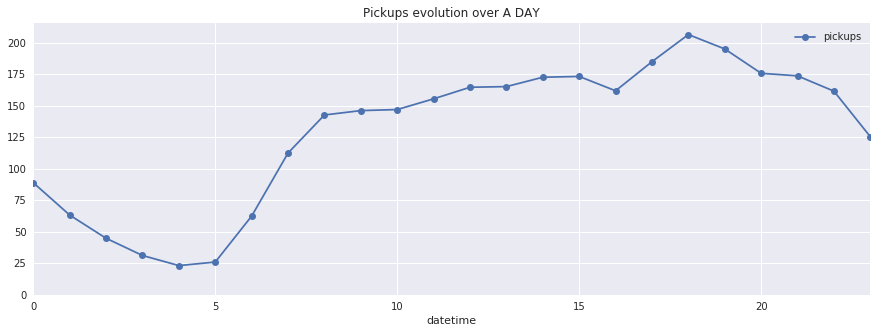

In [10]:
# take 'datetime' and 'pickups' columns
df_grouped = df2[['datetime', 'pickups']]

# MONTHS DATA
df_grouped_months = df_grouped.groupby('datetime').mean().resample('M').mean()

# WEEKS DATA
df_grouped_weeks = df_grouped.groupby('datetime').mean().resample('W').mean()

# WEEKDAY DATA
df_grouped_weekday = df_grouped.groupby('datetime').mean().reset_index()
# create a categorical list to order weekday index
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# define key to groupby: weekday
key = df_grouped_weekday['datetime'].dt.weekday_name
# groupby 'key' (weekday) and reorder index using categorical values
df_grouped_weekday = df_grouped_weekday.groupby(key).mean().reindex(cats)

# HOURLY DATA
df_grouped_hour = df_grouped.set_index('datetime')
df_grouped_hour = df_grouped_hour.groupby(df_grouped_hour.index.map(lambda t: t.hour)).mean()

# PLOT MONTHS
df_grouped_months.plot(style="-o", figsize=(15,5))
plt.title('Pickups evolution over MONTHS')
plt.ylim(bottom=0)

# PLOT WEEKS
df_grouped_weeks.plot(style="-o", figsize=(15,5))
plt.title('Pickups evolution over WEEKS')
plt.ylim(bottom=0)

# PLOT WEEKDAYS
df_grouped_weekday.plot(style="-o", figsize=(15,5))
plt.title('Pickups evolution over A SINGLE WEEK')
plt.ylim(bottom=0)

# PLOT HOURS
df_grouped_hour.plot(style="-o", figsize=(15,5))
plt.title('Pickups evolution over A DAY')
plt.ylim(bottom=0)

plt.show()

# Scatter Plot, Relation between Precipitation and Pickups
<div style = "float:right"><a style="text-decoration:none" href = "#Data-Analysis:-Visualization">Up</a></div>

I created this set of plots to find a correlation between ``precipitation`` and ``pickups``. My hypothesis is that there are more pickups in rainy days, because people that usually walk are more likely to get a taxi.

### First approach, plotting all the data
The scatter plot does not show a clear relation between 'precipitation' and 'pickups'.<br>
The Histogram and Boxplot show that the mayority of the days it does not rain.

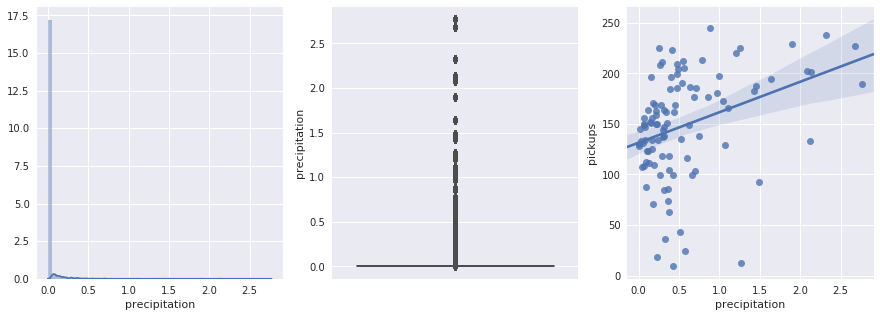

In [11]:
df_grouped = df2[['datetime', 'pickups', 'precipitation']]
df_grouped = df_grouped.groupby('precipitation').mean().reset_index()

fig, ax =plt.subplots(1,3,figsize=(15,5))

sns.distplot(df2['precipitation'], ax=ax[0])
sns.boxplot(data=df2, y='precipitation', ax=ax[1])
sns.regplot(df_grouped['precipitation'], df_grouped['pickups'], ax=ax[2])

fig.show()

### Second approach, plotting only days with precipitation
I don´t still see any correlation.

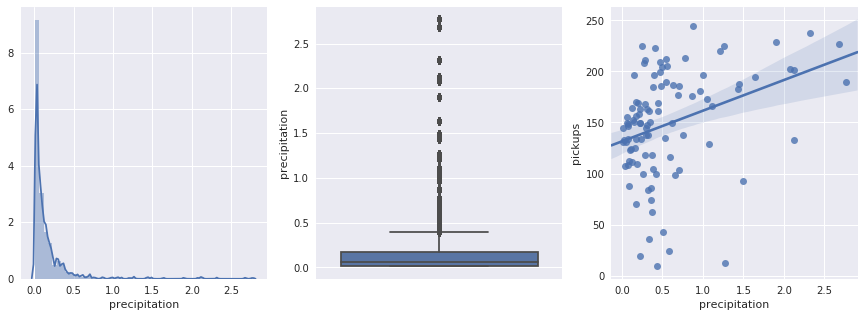

In [12]:
df2_prec = df2[df2['precipitation'] > 0]
df_grouped = df2_prec[['datetime', 'pickups', 'precipitation']]
df_grouped = df_grouped.groupby('precipitation').mean().reset_index()

fig, ax =plt.subplots(1,3,figsize=(15,5))

sns.distplot(df2_prec['precipitation'], ax=ax[0])
sns.boxplot(data=df2_prec, y='precipitation', ax=ax[1])
sns.regplot(df_grouped['precipitation'], df_grouped['pickups'], ax=ax[2])

fig.show()

### Third approach, removing outliers above ``0.5`` precipitation
The scatter plot is very clear: **there is no correlation between ``precipitation`` and ``pickups``.**

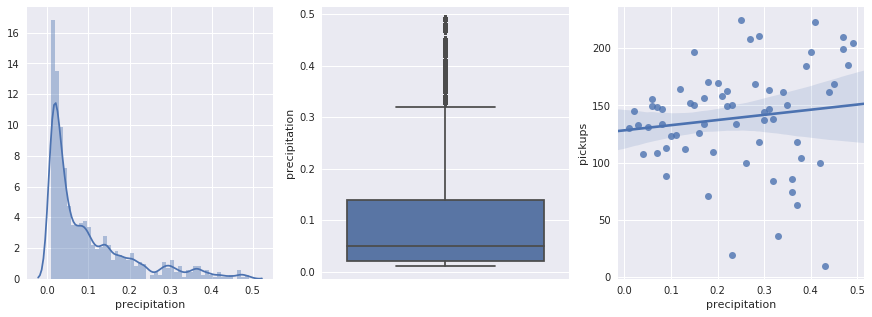

In [13]:
filter1 = df2['precipitation'] > 0
filter2 = df2['precipitation'] < 0.5
df2_prec = df2[filter1 & filter2]
df_grouped = df2_prec[['datetime', 'pickups', 'precipitation']]
df_grouped = df_grouped.groupby('precipitation').mean().reset_index()

fig, ax =plt.subplots(1,3,figsize=(15,5))

sns.regplot(df_grouped['precipitation'], df_grouped['pickups'], ax=ax[2])
sns.boxplot(data=df2_prec, y='precipitation', ax=ax[1])
sns.distplot(df2_prec['precipitation'], ax=ax[0])
fig.show()

#sns.regplot(df_grouped['precipitation'], df_grouped['pickups'])

# Pairwise Relationships
<div style = "float:right"><a style="text-decoration:none" href = "#Data-Analysis:-Visualization">Up</a></div>

As the number of pickups is very stable over time, I will analyse only one month (so it runs faster in my computer)

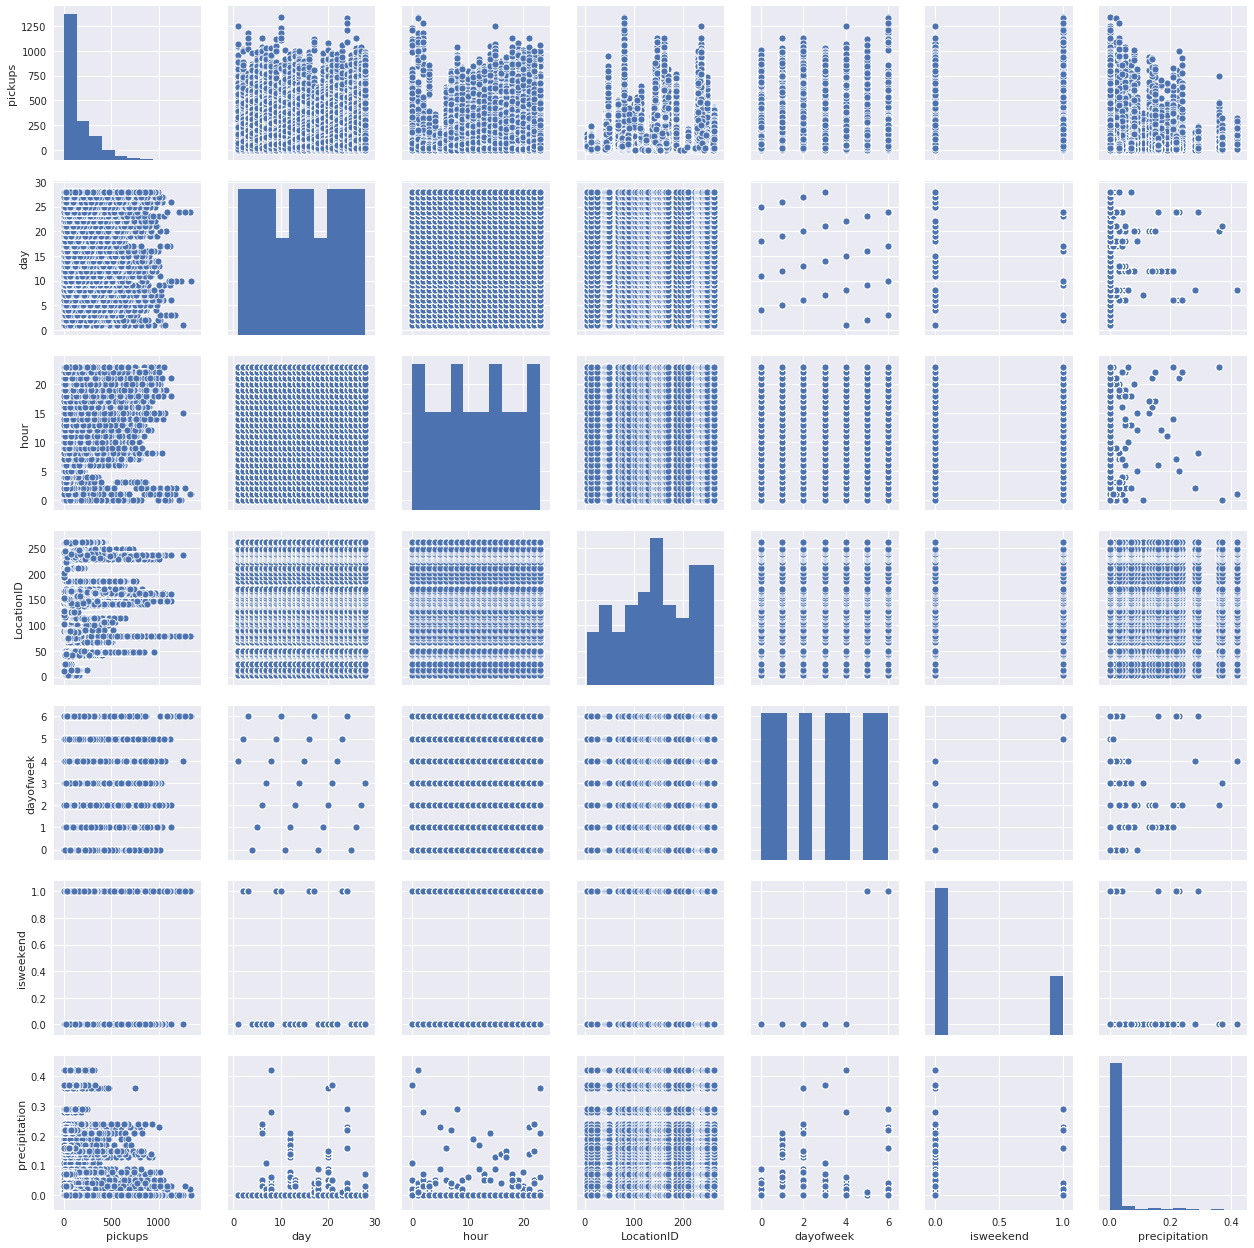

In [14]:
df2 = df[df['month'] == 2]
sns.pairplot(df2[['pickups','day', 'hour', 'LocationID',
       'dayofweek', 'isweekend', 'precipitation']])

Relations found:

- **Pickups - isweekend**. There are more pickups during the weekend.
- **Pickups - dayofweek**. There are more pickups on Saturday, Friday, Thursday. In this order. It is related to ``sweekend`` but it contains more granularity about pickups distribution so I will keep this variable and remove ``is weekend``.
- **Pickups - hour**. There are more pickups between 23:00 and 3:00. This could be because there is not public transport.
- **Pickups - day**. There is a clear weekly pattern so this information is already given by ``dayofweek``. So I will remove ``day``.

# Pickups in Rainy Day vs Not Rainy Days
<div style = "float:right"><a style="text-decoration:none" href = "#Data-Analysis:-Visualization">Up</a></div>

I have compared the average of pickups in rainy days vs not rainy days.

Against my hypothesis, there is no relation at all between rain and pickups.

In [15]:
df2 = df[['month', 'day', 'precipitation','pickups']]
df2 = df2.groupby(['month', 'day']).mean().reset_index()

# convert prediction variable y categorical. 0 = it didn´t rain. 1 = it rained.
df2.loc[(df2.precipitation != 0),'precipitation']=1
df2 = df2.groupby('precipitation')['pickups'].mean().reset_index()

df2.head(20)

,precipitation,pickups
0,0.0,127.548318
1,1.0,131.911881


# Conclusions
<div style = "float:right"><a style="text-decoration:none" href = "#Data-Analysis:-Visualization">Up</a></div>

- Remove features ```day``` and ```isweekend``` as they don´t add any information.
- There is not a strong correlation between ```precipitation``` and ```pickups```. However, after so much work scraping precipitation forecast values from wunderground.com, I will train the models with and without ```precipitation``` and compare the results.
- Pickups are strongly affected by USA Federal Holidays. It is important to create an ```isholiday``` feature.
- Number of pickups is very constant throughout the year, with a small decrease of 15% in summer (July and August).
- Number of pickups is also constant throughout the weeks, with visible decreases on the main USA Federal Holidays.
- The pickups evolution over a week is quite constant with small decreases on Sunday and Monday.
- Pickups evolution over a day is where I see the biggest variation, with 250+ pickups at 18:00-19:00pm and 50 between 1:00-6:00am.
- Important variables:
    - ```dayofweek```
    - ```hour```
    - ```isholiday```
    - ```LocationID```
    - ```month```
    - ```precipitation```